##Introduction

We're going to cover an introduction to interferometer data analysis in this lesson. Interferometers are used in many plasma experiments to make measurements of plasma density. Optical diagnostics like interferometers are important tools for making measurements inside plasmas without changing their behavior - you'll hear people calling these techniques "non-perturbative". We'll apply the filtering techniques we learned earlier and also demonstrate a cool trick for obtaining amplitude/phase information from oscillating signals. At the end of the lesson you'll combine everything we learned to calculate plasma density.

**Principle of operation**

A common interferometer design for plasma diagnostics is known as a Mach-Zehnder interferometer. In this type of interferometer, a probe beam from a single light source is split so that one path goes through the sample to be measured and a second path does not. Interferometry typically uses collimated beams of light - these beams have mostly parallel rays that do not diverge much. Typically that means the source of light is a laser. For our work, the sample is a plasma. Phase shifts caused by the sample/plasma can be measured at the detectors as a fringe pattern.

<p align="center">
  <img width="500" src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Mach-zender-interferometer.png">
</p>

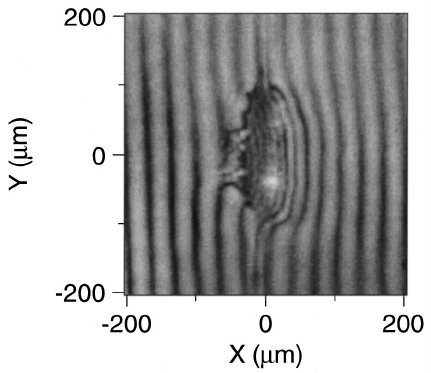

An important modification to this technique is to use two different sources with slightly different frequencies (this is called heterodyne interferometry). One source is used to probe the sample, and the other source acts as a reference which does not pass through the sample. The two different frequencies from each source will produce a beat frequency when they are combined at the detector.

<p align="center">
  <img width="500" src="https://pages.mtu.edu/~suits/beatgraph.gif">
</p>

If the sample index of refraction changes with time (in our case, this means the plasma density), then the measured beat frequency will change with time. We will also need to compare the beat frequency measured by a detector viewing the plasma to the beat frequency measured by a detector that does not view the plasma. Instead of using a spatial fringe pattern like the example above, we will measure the changes in the beat frequency to determine plasma density.

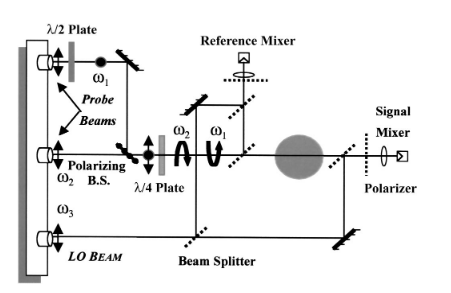

<p align="center">
  <img width="500" src="https://www.thegeekpub.com/wp-content/uploads/2019/08/Oscilloscope-Tutorial-0001-title-image-1280x640.jpg">
</p>

# Review of Zero-Phase Filtering (from last time)

Just a quick refresher on our previous lesson about signal filtering techniques:


1.   We can use FFTs and filters to selectively keep/reject different frequency components in a signal
2.   We have to be careful to balance time resolution and frequency resolution - this is done with different time windows and filter shapes
3.   The package scipy.signal has a lot of useful signal processing functions
4.   Filters can impact both the amplitude and phase of a signal
5.   We saw examples of filters introducing a time delay or artifacts at the beginning of a signal

At the end of the lesson, we were looking at zero-phase filtering as a way to mitigate the problems with time delay so that our filtered signal would match the original signal better.

Let's set up that example one more time:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# define some frequencies for a signal
f1 = 3e4
f2 = 1e5
f3 = 2.5e5

# create time array
nsamples = 512
dt = 1e-6 # step size is us
sample_frequency = 1/dt
time = np.arange(nsamples)*dt

# two of the frequencies will have continuous amplitude, but the third will be pulsed
pulse_amplitude = np.exp(-((time - .0003)**2)/(1e-9) )

# add the frequency content together for our signal
signal_test = np.cos(2*np.pi*time*f1) + np.cos(2*np.pi*time*f2) + pulse_amplitude*np.cos(2*np.pi*time*f3)

# define new filter parameters
order = 8

# define a Bessel filter for the middle frequency f2
cutoff_frequencies = [8e4, 1.2e5]
filter_sos_f2 = signal.bessel(order, cutoff_frequencies, btype='bandpass', output='sos', fs=sample_frequency)

# define a Butterworth filter for the upper frequency f3
cutoff_frequencies = [2e5, 3e5]
filter_sos_f3 = signal.butter(order, cutoff_frequencies, btype='bandpass', output='sos', fs=sample_frequency)

# plot the new signal
plt.plot(time,signal_test)
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')

Zero-phase filtering is accomplished by applying a filter foward in time on a signal, and then applying the filter again except running it backward in time. The result is that the gain for the filter is squared, while the phase response goes to zero. Recall earlier that the filters we were applying had different phases at different frequencies - for a zero-phase filter this is not the case.

Note: This doesn't matter much for the exercises we are doing here, but zero-phase filtering can only be done when you have enough of your signal measured to be able to run a forward-backward filter. This isn't something you can do real-time.

Here's an example of forward-backward filtering using the Bessel filter with the signal.sosfiltfilt function instead of signal.sosfilt (we can call them the same way) to select the middle frequency from this signal. Note how the delayed onset at the beginning is reduced (but now there is also a delay at the end).

In [ ]:
# create a time series with just the f2 component for comparison
signal_f2 = np.cos(2*np.pi*time*f2)

# filter the signal with the Bessel filter and forward filtering with sosfilt
signal_filtered = signal.sosfilt(filter_sos_f2, signal_test)

# plot the filtered signal and the original component
plt.plot(time, signal_f2, label='Ideal Filtered Signal')
plt.plot(time, signal_filtered, label='Actual Filtered Signal')
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')
plt.legend()

In [ ]:
# filter the signal with the Bessel filter we used above but now using zero-phase filtering with sosfiltfilt
signal_filtered = signal.sosfiltfilt(filter_sos_f2, signal_test)

# plot the zero-phase filtered signal and the original component
plt.plot(time, signal_f2, label='Ideal Filtered Signal')
plt.plot(time, signal_filtered, label='Actual Filtered Signal')
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')
plt.legend()

**Exercise 1**

Now try zero-phase filtering on the pulsed signal!

In [ ]:
# Try it out here!

# isolate just the pulsed component from the original signal for comparison
signal_f3 = pulse_amplitude*np.cos(2*np.pi*time*f3)

# filter the signal with the Butterworth filter from above first using forward filtering with sosfilt
# and then using zero-phase filtering with sosfiltfilt
signal_filtered_zerophase = signal.sosfiltfilt(filter_sos_f3, signal_test)

In [ ]:
# plot the zero-phase filtered signal and the original component
plt.plot(time, signal_f3, label='Ideal Filtered Signal')
plt.plot(time, signal_filtered_zerophase, label='Actual Filtered Signal')
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')
plt.legend()

##Hilbert transforms and analytic signals

This technique is maybe not as common, but really powerful. For our given input signal, we can construct something called an analytic signal using the Hilbert transform. The Hilbert transform has the effect of shifting the phase of negative frequency components by 90 degrees and the phase of positive frequency components by -90 degrees. This may seem weird - why would we do this? For a signal, $s(t)$, with Hilbert transform

$H( s(t) )$

the analytic signal is defined as:

$s_{analytic}(t) = s(t) + i * H( s(t) )$

and since the complex $i$ also applies a 90 degree phase shift, the second term will have negative frequency components with opposite sign from the original signal. This means that the negative frequency components cancel out and the analytic signal only has positive frequencies.

That's neat! But still weird, right? What would we use this for?

It turns out that we can get two really useful quantities from the analytic signal:

1.   Instantaneous amplitude (or envelope): the magnitude of the analytic signal is the envelope of the original signal. You can get this with np.abs( $s_{analytic}$ ).
2.   Instantaneous phase: the phase angle of the complex valued analytic signal corresponds to the phase of the input sinusoid. You can get this with np.angle( $s_{analytic}$ ) or by using the arctan function on the real and imaginary components - atan2(x.imag, x.real)

<p align="center">
  <img width="300" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Complex_number_illustration_modarg.svg">
</p>

The analytic signal can be calculated using the function signal.hilbert (I'm sorry, the name is really confusing but the output here is actually the analytic signal, not the Hilbert transform).

**Exercise 2**

Try this out on one of the signals from earlier (signal_f2 or signal_f3) - calculate the analytic signal and use it to determine the instantaneous amplitude and phase.

In [ ]:
# Try it out here!
signal_analytic = signal.hilbert(signal_f3)
envelope = np.abs(signal_analytic)
instant_phase = np.angle(signal_analytic)

In [ ]:
# plot the original component and the envelope
plt.plot(time, signal_f3, label='Signal')
plt.plot(time, envelope, label='Envelope')
plt.ylabel('Signal (arb)')
plt.xlabel('Time (s)')
plt.legend()

In [ ]:
# plot the instantaneous phase
plt.plot(time, instant_phase)
plt.ylabel('Phase (rad)')
plt.xlabel('Time (s)')

# a useful tool is the numpy unwrap function
phase_unwrap = np.unwrap(instant_phase)
plt.plot(time, phase_unwrap)

# zoom in on some features
plt.xlim(.0003,.0004) # try changing the zoom
plt.axhline(np.pi,color='k')
plt.axhline(-np.pi,color='k')

Note that you can use np.unwrap to do what the name suggests - "unwrap" a set of phase values so that they change smoothly instead of having discontinuities where the values cross from +pi to -pi.



---




#TAKE A BREAK HERE



---



#Check out this real data!

We've spent enough time on those simulated signals, right?

Let's apply what we know to real data from a real experiment. First we need to load the data - **download the signal file from Google drive, then upload it to your Colab session using the file icon on the left**.

We are going to use a cool package called pandas to import our data. Full disclosure - I am not a big fan of the documentation for pandas. But it can give you powerful tools for handling tables and time series data, and it can read a lot of different file types, including the HDF5 file type used here.

In [ ]:
# TRY THIS METHOD FIRST TO LOAD THE DATA

# run this to import the data after uploading the data file
import pandas as pd

# use pandas to read hdf5 file with raw data
# df = pd.read_hdf('/content/MST_FIR_1220804040.h5', 'df')

In [ ]:
# get the names of the columns in this table
print('COLUMNS')
print(df.columns)

# what are the types of data in each column? just ask
print('DATA TYPES')
print(df.dtypes)

# get columns from pandas dataframe and convert back to numpy arrays
time = df['time'].to_numpy()
signal1 = df['ref'].to_numpy()
signal2 = df['n02'].to_numpy()

# calculate the time step size
nsamples = len(time)
dt = (time[-1] - time[0])/(len(time)-1)

Ok, so now we've got some data. What is it? Remember from the introduction, this measurement involves a beat frequency between two lasers, and we are measuring that beat frequency on two different detectors. Let's take a look at the Fourier transform of one of these signals.

In [ ]:
from scipy.fft import fft, fftfreq

# use the fftfreq helper function to determine the frequencies based on the input time series
frequencies = fftfreq(nsamples, dt)
signal1_fft = fft(signal1)
signal2_fft = fft(signal2)

# Plot the spectrum of the reference signal
plt.plot(frequencies/(1e6), np.abs(signal1_fft), label='Reference Signal')
#plt.plot(frequencies/(1e6), np.abs(signal2_fft), label='Probe Signal')
plt.xlim(0,2)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Signal (arb)')
plt.legend()
plt.show()

**Exercise 3**

Apply the Hilbert transform technique we used earlier to calculate the envelope of the "probe" signal, in this case signal2.

BONUS: Find the time point where the amplitude is the lowest.

In [ ]:
# Try it out here!
signal_analytic = signal.hilbert(signal2)
envelope = np.abs(signal_analytic)
minIndex = np.argmin(envelope)
minTime = time[minIndex]
print(minTime)

In [ ]:
# Plot the envelope of the reference signal
plt.plot(time, signal2, label='Probe Signal')
plt.plot(time, envelope, label='Instantaneous Amplitude')
plt.xlim(0,.01) # try changing the zoom
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

#Exploring the phase

We're going to look a little bit more closely at the instantaneous phase that we can calculate from the analytic signal. First, let's calculate the product of the reference analytic signal and the probe analytic signal with one of the signals complex conjugated first.

In [ ]:
# calculating a product
reference_analytic = signal.hilbert(signal1)
probe_analytic = signal.hilbert(signal2)
product_analytic = reference_analytic.conjugate()*probe_analytic

What have I just done?!

**Exercise 4**

Calculate the instantaneous phase of one of the original signals (signal1 or signal2) and compare it to the instantaneous phase of this product that we just calculated.

In [ ]:
# Try it out here!
phase_reference = np.angle(reference_analytic) # or phase_probe
phase_product = np.angle(product_analytic)

In [ ]:
# plot the instantaneous phase
plt.plot(time, phase_reference, label='Reference Phase')
plt.plot(time, phase_product, label='Product Phase')
plt.ylabel('Phase (rad)')
plt.xlabel('Time (s)')
plt.legend()

# zoom in to see things more clearly
plt.xlim(.010,.01001)
plt.axhline(np.pi,color='k')
plt.axhline(-np.pi,color='k')

In [ ]:
# what if we look at this with np.unwrap?
phase_reference_unwrap = np.unwrap(phase_reference)
phase_product_unwrap = np.unwrap(phase_product)
plt.plot(time, phase_reference_unwrap, label='Reference Phase')
plt.plot(time, phase_product_unwrap, label='Product Phase')
plt.legend()

plt.ylabel('Phase (rad)')
plt.xlabel('Time (s)')
#plt.ylim(-10,10)

Remember Euler's formula:

$e^{ix} = cos(x) + i \cdot sin(x)$

If we represent our reference signal as just the beat frequency:

$s_{ref} = e^{i\omega_{beat}t}$

and our probe signal has the beat frequency plus additional frequency content from the plasma (denoted here by $\phi(t)$)

$s_{probe} = e^{i\omega_{beat}t + i\phi(t)}$

when we calculated that product above with the reference signal complex conjugated, the $e^{i\omega_{beat}t}$ terms cancelled out, leaving

$s_{product} = s_{ref}^* \cdot s_{probe} = e^{i\phi(t)}$

So this gives us a great tool to remove the laser beat frequency from our measurement and leave just the changes in phase due to the plasma index of refraction.

##Putting it all together

So we can use the techniques above to calculate the phase change in our signal. But what does it mean?

The phase of an interferometer is related to the plasma electron density:

$\phi(t) = \frac{-e^2}{2c\omega m_e\epsilon_0} \int n_e dl$

Note that the $\int n dl$ term means that this is a line-integrated measurement - interferometry doesn't give you local density! The measurement is integrated along the entire path length through the plasma, and has units of particles per square meter.

To convert the phase measurements we got above into density, we need the conversion factor representing that fraction outside the integral. For this laser, the conversion factor is:

coefficient = 8.22e17 $\frac{particles}{rad \cdot m^2}$

We'll ignore the negative sign in the equation above - it's common practice to just set the sign of your density measurement so that it is positive because negative density isn't physical.

So let's calculate the density of our plasma! Remember:

We will want to bandpass filter each raw signal first - the beat frequency is at 1.05 MHz for this shot and a filter bandwidth of 200 kHz should work. After filtering, we want to construct the analytic signal for both of the raw signals. Calculate the product of the two analytic signals (remember to conjugate one of them first). Then we can calculate the phase of the resulting product (don't forget to unwrap the phase), and convert the phase to density.

Now put together the tools you used above!

**Exercise 4**

In [ ]:
# Try it out here!
conversion = 8.22e17

# define filter parameters
order = 8
cutoff_frequencies = [0.85e3,1.25e6]
sample_frequency = 1/dt

# define a Butterworth filter and filter both raw signals
filter_sos = signal.butter(order, cutoff_frequencies, btype='bandpass', output='sos', fs=sample_frequency)
signal_filtered1 = signal.sosfilt(filter_sos, signal_test)
signal_filtered2 = signal.sosfilt(filter_sos, signal_test)

# calculate analytic signal for both filtered signals
signal_analytic1 = signal.hilbert(signal_filtered1)
signal_analytic2 = signal.hilbert(signal_filtered2)

# calculate the product of the analytic signals and unwrap phase
product = signal_analytic1.conjugate() * signal_analytic2
instant_phase = np.angle(product)
phase_unwrap = np.unwrap(instant_phase)


#calculate density
density = np.exp(phase_unwrap)

In [ ]:
# plot the density time series
plt.plot(time, density)
plt.ylabel('Density (particles/m^2)')
plt.xlabel('Time (s)')

## Bonus Homework: Peak Finding

Interferometers are sensitive to refraction. If the wavelength of the light is short enough, the effect of refraction is small. But if we use a long enough wavelength of light, density gradients in the plasma will refract the beam strongly enough to bend the light away from the detector. This causes a loss of signal and can reduce the quality of the interferometry data.

Look for time points where refraction causes the signal level to drop. First calculate the envelope of the probe signal, and then use the scipy signal.find_peaks routine to identify time points where the signal is low.


In [ ]:
#Code here
